This tutorial tries to explain what are the different steps to follow to implement a series of image processing functions in a dataset.

We will:
* Create a dataset.
* Find different motor positions and reshape the data into these dimensions.
* Apply different image processing techniques like background substraction and hot pixel removal.
* Apply a region of interest to the images to decrease CPU time and memory RAM.
* Find and apply a linear shift between the images.
* Improve this linear shift with the help of random search and genetic search algorithms.
* Find the different components that create the dataset by the means of blind source separation algorithms.
* Link the components between different dataset with feature matching algorithms.

All operations are interchangeable, which means they can be applied in different orders, but it is important to apply the region of interest as soon as possible to decrease the computational time, especially in large datasets.

In [1]:
from matplotlib import pyplot as plt

In [2]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.jet)
    ax1.set_title('original')
    ax2.imshow(filtered, cmap=plt.cm.jet)
    ax2.set_title(filter_name)

### Dataset

In [27]:
import glob
import os
import numpy
from darfix.core.dataset import Dataset

dataset = Dataset(_dir="/home/julia/Documents/tests/darfix/reduced_strain")

In [28]:
from darfix.core.dimension import POSITIONER_METADATA
dataset.find_dimensions(POSITIONER_METADATA)

In [29]:
dataset.remove_dim(1)
dataset.remove_dim(2)
dataset.add_dim(1, dataset.dims.get(3))
dataset.remove_dim(3)

In [30]:
dataset.dims.get(0).set_unique_values(dataset.dims.get(0).unique_values)

In [ ]:
plot_comparison(dataset.get_data(13), dataset.get_data(16), "")

In [ ]:
reshaped_dataset = dataset.reshape_data()

### ROI

In [11]:
from darfix.core import roi

roi_dataset = reshaped_dataset.apply_roi(origin=[900, 750], size=[500, 500])
# dataset.empty_frames = roi.apply_3D_ROI(dataset.empty_frames, [317, 250], [1170, 991])
# dataset.dark_frames = roi.apply_3D_ROI(dataset.dark_frames, [317, 250], [1150, 991])

Applying roi |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


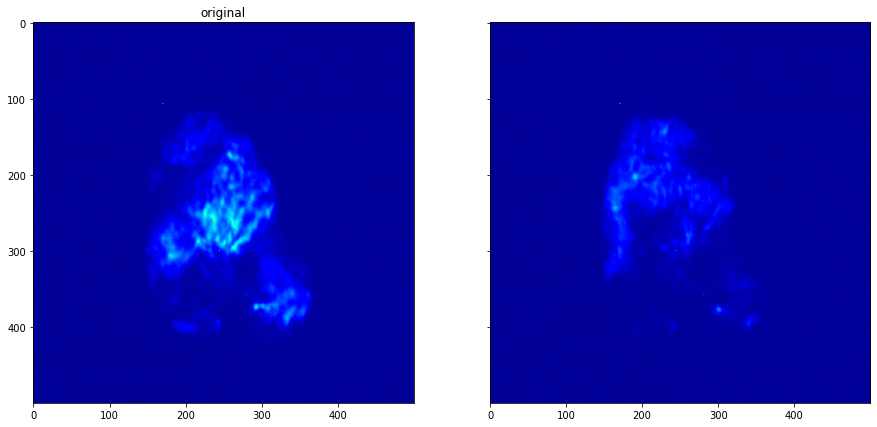

In [12]:
plot_comparison(roi_dataset.get_data(13), roi_dataset.get_data(16), "")

## Filter data

In [13]:
hi_indices, li_indices = roi_dataset.partition_by_intensity()

Computing intensity |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [14]:
li_indices.shape

(30,)

### Background subtraction

In [15]:
bs_dataset = roi_dataset.apply_background_subtraction(method="mean")

Computing mean image |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Applying background subtraction |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


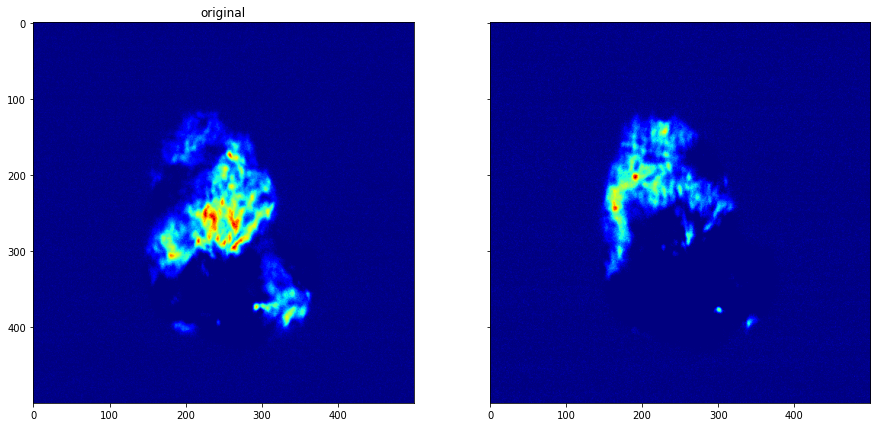

In [16]:
plot_comparison(bs_dataset.get_data(13), bs_dataset.get_data(16), "")

### Hot Pixel Removal

In [17]:
hp_dataset = bs_dataset.apply_hot_pixel_removal()

Applying hot pixel removal |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


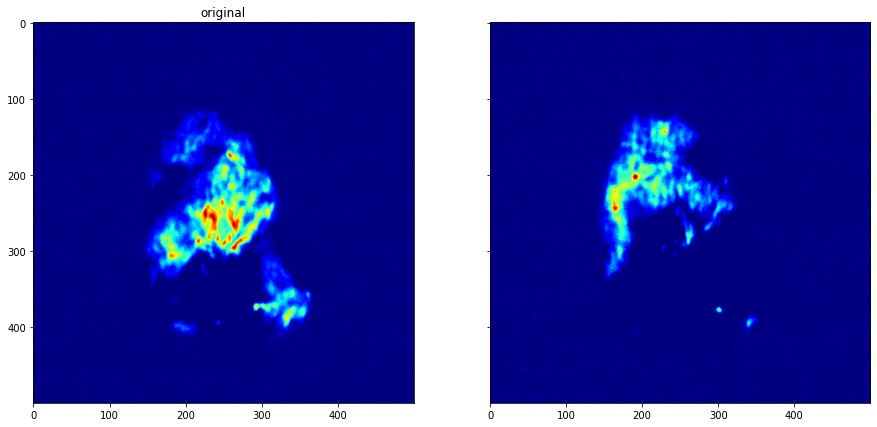

In [18]:
plot_comparison(hp_dataset.get_data(13), hp_dataset.get_data(16), "")

### Threshold removal

In [25]:
tp_dataset = hp_dataset.apply_threshold_removal(bottom=10)

Applying threshold |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


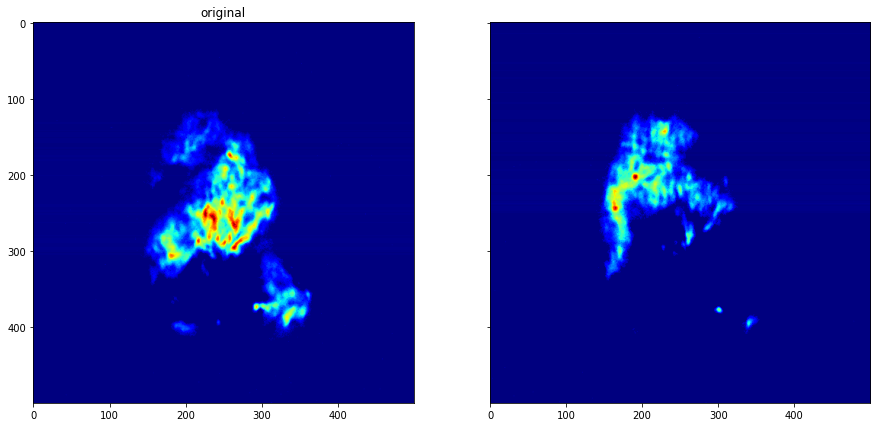

In [26]:
plot_comparison(tp_dataset.get_data(13), tp_dataset.get_data(16), "")

### Shift Detection

In [21]:
shift_dataset = tp_dataset.find_and_apply_shift(dimension=([0], [0]))

Finding shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Applying shift |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [ ]:
plot_comparison(shift_dataset.get_data(13), shift_dataset.get_data(16), "")

In [ ]:
zsum = shift_dataset.get_data(0)
for i in range(1, shift_dataset.nframes):
    zsum += shift_dataset.get_data(i)
    
plt.imshow(zsum, cmap="jet")

In [ ]:
zsum.shape

## BSS

In [ ]:
vals = shift_dataset.pca(return_vals=True)
vals = vals / numpy.sum(vals)
n_components = len(vals[vals > 0.01])
n_components

In [ ]:
# Compute NNICA+NMF to find the components
comp, W = shift_dataset.nica(n_components)

In [ ]:
fig, ax = plt.subplots(ncols=n_components, figsize=(50, 5), sharex=True,
                               sharey=True)

# print(components.shape)
plt.suptitle("NNICA components of dataset")
for i in numpy.arange(n_components):
    ax[i].imshow(comp[i].reshape(shift_dataset.get_data(0).shape), cmap="jet")
    ax[i].axis("off")

In [ ]:
from darfix.io.utils import write_components

h, w = shift_dataset.get_data(0).shape
write_components("components", "entry", shift_dataset.get_dimensions_values(), W, comp.reshape((n_components, h, w)), "1")

## Feature Matching

In [ ]:
from darfix.core.componentsMatching import ComponentsMatching, Method
from darfix.io.utils import read_components

db1 = "components"
db2 = "components"


dimensions1, components1, W1 = read_components(db1)
dimensions2, components2, W2 = read_components(db2)

componentsMatching = ComponentsMatching(components=[components1, components2])
print(components1.shape)

final_matches, matches = componentsMatching.match_components(method=Method.orb_feature_matching)

draws = numpy.array(componentsMatching.draw_matches(final_matches,
                    matches, displayMatches=False))

In [ ]:
rows = 5
cols = int(len(draws)/rows)
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(50, 20))

# print(components.shape)
plt.suptitle("Linked components from two different layers of HEAT 1")
for i in range(rows):
    for j in numpy.arange(cols):
        ax[i][j].imshow(draws[i*cols + j], cmap="jet")
        ax[i][j].axis("off")
        if i*cols + j in final_matches:
            ax[i][j].set_title("{}, {}".format(i*cols + j, final_matches[i*cols + j]))
        else:
            ax[i][j].set_title("{}, -".format(i*cols + j))